In [4]:
import os, sys
import numpy as np
import torch
import torchvision
from tqdm import tqdm
import skimage.segmentation as segmentation
import sklearn.cluster as cluster
from multiprocessing import dummy as multiprocessing
# import multiprocessing
from datetime import datetime

from ace_helpers import *
from utils import ensure_dir, save_torch, informal_log
from visualizations import show_image, show_image_rows
from ace import ConceptDiscovery

In [7]:
def main(verbose=True):
    data_path = 'data/full_ade20k_imagelabels.pth'
    save_dir = 'temp_save'
    ensure_dir(save_dir)
    log_path = os.path.join(save_dir, 'log.txt')
    
    n_samples = 16 # Chose this for 50 * n_classes; ACE chose 50 images per class
    seed = 0
    num_workers = 8
    image_shape = (224, 224)
    slic_params = {
        'n_segments': [15, 50, 80],
        'compactness': [10, 10, 10]
    }
    average_pixel_value = np.mean([0.485, 0.456, 0.406]) * 255 # ImageNet values
    
    # Load data paths
    ade20k_data = torch.load(data_path)
    train_paths = np.array(ade20k_data['train'])
    n_training_samples = len(train_paths)

    # select n_samples images to extract concepts from
    if seed is not None:
        np.random.seed(seed)
    random_idxs = np.random.choice(n_training_samples, size=n_samples, replace=False)

    # Select paths
    paths = train_paths[random_idxs]

    images = load_images_from_files(
        filenames=paths,
        max_imgs=n_samples,
        return_filenames=False,
        do_shuffle=False,
        run_parallel=True,
        shape=image_shape)
    if verbose:
        informal_log("Loaded {} images of shape {}".format(images.shape[0], images.shape[1:]),
                    log_path, timestamp=True)
    
    # Create concept discovery object
    cd = ConceptDiscovery(
        average_image_value=average_pixel_value,
        image_shape=image_shape,
        num_workers=num_workers,
        checkpoint_dir=save_dir)
    if verbose: 
        informal_log("Creating patches...", log_path, timestamp=True)
    cd.create_patches(
        method='slic',
        param_dict=slic_params,
        discovery_images=images)
    if verbose:
        informal_log("Saving patches...", log_path, timestamp=True)
    cd.save()
    return cd
    
cd = main()

[0731_153243] Loaded 16 images of shape (224, 224, 3)
[0731_153243] Creating patches...
[0731_153247] Created patches for 4/16 samples...
[0731_153247] Created patches for 8/16 samples...
[0731_153251] Created patches for 12/16 samples...
[0731_153251] Created patches for 16/16 samples...
[0731_153252] Saving patches...
Saved dataset, image numbers, and patches to temp_save/cd_data.pth


(1768, 224, 224, 3)
(8, 224, 224, 3)
224


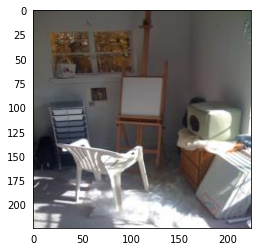

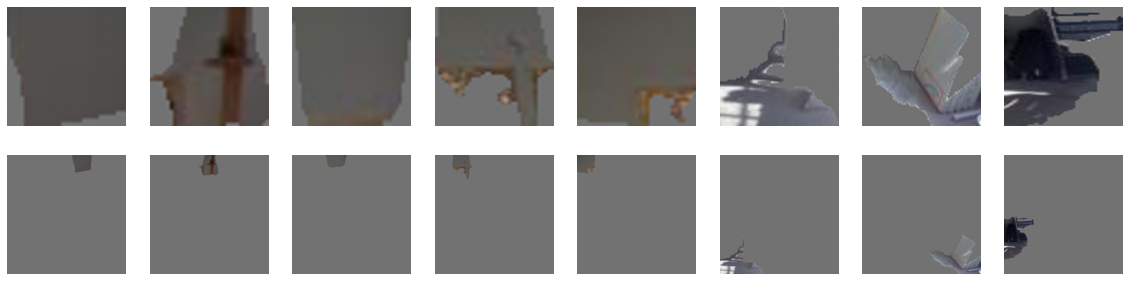

(<Figure size 1440x360 with 16 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >]], dtype=object))

In [18]:
dataset = cd.dataset
print(dataset.shape)
discovery_images = cd.discovery_images
patches = cd.patches
image_numbers = cd.image_numbers

n_show = 8
start = 1750
superpixels = dataset[start:start+n_show]
print(superpixels.shape)
patches = patches[start:start+n_show]
image_idx = image_numbers[start]
di = discovery_images[image_idx]
print(len(dataset[idx]))

show_image(di)
show_image_rows(
    [superpixels, patches])

## Function definitions

In [8]:
def load_features_model(arch,
                  n_classes,
                  device,
                  checkpoint_path=None):
    '''
    Build model from torchvision and load checkpoint. Return model and features model (cut off last layer)
    
    Arg(s):
        arch : str
            model architecture as specific in torchvision.models.__dict__
        n_classes : int
            number of classes to predict
        checkpoint_path : str or None
            path to restore model weights from
        device : torch.device
            Device to load model on
            
    Returns:
        model, features_model
            model : restored model
            features_model : model without the final classification layer
    '''
    model = torchvision.models.__dict__[arch](num_classes=n_classes)
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
        # Get rid of 'module' from the keys which is due to multi-GPU training
        state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict)
    model.eval()
    features_model = torch.nn.Sequential(*list(model.children())[:-1])
    features_model.eval()
    
    return model, features_model

In [9]:
# class ConceptDiscovery(object):
#     def __init__(self,
#                  num_workers=100,
#                  average_image_value=117,
#                  image_shape=(224, 224),
#                  checkpoint_dir='temp_save',
#                  seed=None):
#         self.num_workers = num_workers
#         self.average_image_value = average_image_value
#         self.image_shape = image_shape
#         self.checkpoint_dir = checkpoint_dir
#         ensure_dir(self.checkpoint_dir)
        
#         self.seed = seed
        
#         self.discovery_images = None
#         self.dataset, self.image_numbers, self.patches =\
#             None, None, None
#         self.features = None
        
#     def create_patches(self, method='slic', discovery_images=None,
#          param_dict=None):
#         """Creates a set of image patches using superpixel methods.

#         This method takes in the concept discovery images and transforms it to a
#         dataset made of the patches of those images.

#         Args:
#         method: The superpixel method used for creating image patches. One of
#         'slic', 'watershed', 'quickshift', 'felzenszwalb'.
#         discovery_images: Images used for creating patches. If None, the images in
#         the target class folder are used.

#         param_dict: Contains parameters of the superpixel method used in the form
#         of {'param1':[a,b,...], 'param2':[z,y,x,...], ...}. For instance
#         {'n_segments':[15,50,80], 'compactness':[10,10,10]} for slic
#         method.
#         """
#         if param_dict is None:
#             param_dict = {}
#         dataset, image_numbers, patches = [], [], []
#         if discovery_images is None:
#             raise ValueError("Must pass in np.array for discovery_images. Received {}".format(
#                 type(discovery_images)))
#             # raw_imgs = self.load_concept_imgs(
#             #     self.target_class, self.num_discovery_imgs)
#             # self.discovery_images = raw_imgs
#         else:
#             self.discovery_images = discovery_images
        
#         if self.num_workers:
#             pool = multiprocessing.Pool(self.num_workers)
#             outputs = pool.map(
#                 lambda img: self._return_superpixels(img, method, param_dict),
#                 self.discovery_images)
#             for fn, sp_outputs in enumerate(outputs):
#                 image_superpixels, image_patches = sp_outputs
#                 for superpixel, patch in zip(image_superpixels, image_patches):
#                     dataset.append(superpixel)
#                     patches.append(patch)
#                     image_numbers.append(fn)
#         else:
#             for fn, img in tqdm(enumerate(self.discovery_images)):
#                 image_superpixels, image_patches = self._return_superpixels(
#                     img, method, param_dict)
#                 for superpixel, patch in zip(image_superpixels, image_patches):
#                     dataset.append(superpixel)
#                     patches.append(patch)
#                     image_numbers.append(fn)
#         self.dataset, self.image_numbers, self.patches =\
#         np.array(dataset), np.array(image_numbers), np.array(patches)

#     def _return_superpixels(self, img, method='slic',
#               param_dict=None):
#         """Returns all patches for one image.

#         Given an image, calculates superpixels for each of the parameter lists in
#         param_dict and returns a set of unique superpixels by
#         removing duplicates. If two patches have Jaccard similarity more than 0.5,
#         they are concidered duplicates.

#         Args:
#         img: The input image
#         method: superpixel method, one of slic, watershed, quichsift, or
#         felzenszwalb
#         param_dict: Contains parameters of the superpixel method used in the form
#         of {'param1':[a,b,...], 'param2':[z,y,x,...], ...}. For instance
#         {'n_segments':[15,50,80], 'compactness':[10,10,10]} for slic
#         method.
#         Raises:
#         ValueError: if the segementation method is invaled.
#         """
#         if param_dict is None:
#             param_dict = {}
#         if method == 'slic':
#             n_segmentss = param_dict.pop('n_segments', [15, 50, 80])
#             n_params = len(n_segmentss)
#             compactnesses = param_dict.pop('compactness', [20] * n_params)
#             sigmas = param_dict.pop('sigma', [1.] * n_params)
#         elif method == 'watershed':
#             markerss = param_dict.pop('marker', [15, 50, 80])
#             n_params = len(markerss)
#             compactnesses = param_dict.pop('compactness', [0.] * n_params)
#         elif method == 'quickshift':
#             max_dists = param_dict.pop('max_dist', [20, 15, 10])
#             n_params = len(max_dists)
#             ratios = param_dict.pop('ratio', [1.0] * n_params)
#             kernel_sizes = param_dict.pop('kernel_size', [10] * n_params)
#         elif method == 'felzenszwalb':
#             scales = param_dict.pop('scale', [1200, 500, 250])
#             n_params = len(scales)
#             sigmas = param_dict.pop('sigma', [0.8] * n_params)
#             min_sizes = param_dict.pop('min_size', [20] * n_params)
#         else:
#             raise ValueError('Invalid superpixel method!')
        
#         unique_masks = []
#         for i in range(n_params):
#             param_masks = []
#             if method == 'slic':
#                 segments = segmentation.slic(
#                     img, n_segments=n_segmentss[i], compactness=compactnesses[i],
#                     sigma=sigmas[i])
#             elif method == 'watershed':
#                 segments = segmentation.watershed(
#                     img, markers=markerss[i], compactness=compactnesses[i])
#             elif method == 'quickshift':
#                 segments = segmentation.quickshift(
#                     img, kernel_size=kernel_sizes[i], max_dist=max_dists[i],
#                     ratio=ratios[i])
#             elif method == 'felzenszwalb':
#                 segments = segmentation.felzenszwalb(
#                     img, scale=scales[i], sigma=sigmas[i], min_size=min_sizes[i])
#             for s in range(segments.max()):
#                 mask = (segments == s).astype(float)
#                 if np.mean(mask) > 0.001:
#                     unique = True
#                     for seen_mask in unique_masks:
#                         jaccard = np.sum(seen_mask * mask) / np.sum((seen_mask + mask) > 0)
#                         if jaccard > 0.5:
#                             unique = False
#                             break
#                     if unique:
#                         param_masks.append(mask)
#             unique_masks.extend(param_masks)
        
#         superpixels, patches = [], []
#         while unique_masks:
#             superpixel, patch = self._extract_patch(img, unique_masks.pop())
#             superpixels.append(superpixel)
#             patches.append(patch)
#         return superpixels, patches

#     def _extract_patch(self, image, mask):
#         """Extracts a patch out of an image.

#         Args:
#         image: The original image
#         mask: The binary mask of the patch area

#         Returns:
#         image_resized: The resized patch such that its boundaries touches the
#         image boundaries
#         patch: The original patch. Rest of the image is padded with average value
#         """
#         mask_expanded = np.expand_dims(mask, -1)
#         patch = (mask_expanded * image + (
#             1 - mask_expanded) * float(self.average_image_value) / 255)
#         ones = np.where(mask == 1)
#         h1, h2, w1, w2 = ones[0].min(), ones[0].max(), ones[1].min(), ones[1].max()
#         image = Image.fromarray((patch[h1:h2, w1:w2] * 255).astype(np.uint8))
#         image_resized = np.array(image.resize(self.image_shape,
#                                               Image.BICUBIC)).astype(float) / 255
#         return image_resized, patch
    
#     def save(self):
#         save_data = {
#             'dataset': self.dataset,
#             'image_numbers': self.image_numbers,
#             'patches': self.patches,
#             'features': self.features
#         }
#         save_path = os.path.join(self.checkpoint_dir, 'cd_data.pth')
#         torch.save(save_data, save_path)
#         print("Saved dataset, image numbers, and patches to {}".format(save_path))
        
#     def restore(self, restore_path):
#         restore_data = torch.load(restore_path)
#         if restore_data['dataset'] is not None:
#             self.dataset = restore_data['dataset']
#         if restore_data['image_numbers'] is not None:
#             self.image_numbers = restore_data['image_numbers']
#         if restore_data['patches'] is not None:
#             self.patches = restore_data['patches']
#         if restore_data['features'] is not None:
#             self.features = restore_data['features']
            
#     def print_shapes(self):
#         if self.dataset is not None:
#             print("Dataset (superpixel) shape: {}".format(self.dataset.shape))
#         if self.image_numbers is not None:
#             print("Image numbers shape: {}".format(self.image_numbers.shape))
#         if self.patches is not None:
#             print("Patches shape: {}".format(self.patches.shape))
#         if self.features is not None:
#             print("Features shape: {}".format(self.features.shape))
            
#     def get_features(self,
#                      features_model,
#                      device,
#                      batch_size=256,
#                      channel_mean=True,
#                      dataset=None):
#         features = []
        
#         features_model.eval()
#         features_model = features_model.to(device)
#         if dataset is None:
#             if self.dataset is None:
#                 raise ValueError("No dataset passed in and self.dataset is None. First run cd.create_patches()")
#             dataset = self.dataset
#         n_batches = int(dataset.shape[0] / batch_size) + 1
#         with torch.no_grad():
#             for batch_idx in tqdm(range(n_batches)):
#                 batch = dataset[batch_idx * batch_size : (batch_idx + 1) * batch_size]
#                 batch = torch.tensor(batch, dtype=torch.float)
#                 batch = torch.permute(batch, (0, 3, 1, 2))
#                 batch = batch.to(device)
                
#                 batch_features = features_model(batch).cpu().numpy()
#                 features.append(batch_features)
#         features = np.concatenate(features, axis=0)
        
#         # Flatten features to n_samples x feature_dim array either by taking mean across channels
#         # Or expanding channel to 1D array
#         if channel_mean and len(features.shape) > 3:
#             features = np.mean(features, axis=(2, 3))
#         else: 
#             features = np.reshape(features, [features.shape[0], -1])
#         assert features.shape[0] == dataset.shape[0]
        
#         if dataset is None:
#             self.features = features
        
#         else:
#             return features
        
    
#     def discover_concepts(self,
#                           cluster_params,
#                           cluster_method,
#                           save=False):
        
#         cluster_assignments, cluster_costs, cluster_centers = self._cluster_patches(
#             cluster_params=cluster_params,
#             cluster_method=cluster_method,
#             features=self.features)
        
#         # If for some reason cluster_centers is 1 x C x D, squeeze it to be C x D
#         if len(cluster_centers.shape) == 3:
#             cluster_centers = np.squeeze(cluster_centers)
            
#         if save:
#             save_dir = self.checkpoint_dir
#         else:
#             save_dir = None
#         concept_centers, top_concept_image_data = self._filter_concepts(
#             assignments=cluster_assignments,
#             costs=cluster_costs,
#             centers=cluster_centers,
#             save_dir=save_dir)
        
#         return concept_centers, top_concept_image_data
            
#     def _cluster_patches(self,
#                         cluster_params,
#                         cluster_method='KM',
#                         features=None):
#         if features is None:
#             if self.features is None:
#                 raise ValueError("No features passed in and self.features is None. First run cd.get_features()")
#             features = self.features
            
#         if cluster_method == 'KM':
#             n_clusters = cluster_params.pop('n_clusters', 25)
#             kmeans = cluster.KMeans(
#                 n_clusters,
#                 random_state=self.seed)
#             kmeans = kmeans.fit(features)
#             centers = kmeans.cluster_centers_
            
#             # Calculate distance between each feature and each cluster
#             features = np.expand_dims(features, 1)  # N x 1 x D
#             centers = np.expand_dims(centers, 0) # 1 x C x D
#             distance = np.linalg.norm(features - centers, ord=2, axis=-1) # N x C matrix
            
#             # For each sample, get cluster assignment
#             assignments = np.argmin(distance, -1)  # N-dim vector
#             costs = np.min(distance, -1)  # N-dim vector
#             return assignments, costs, centers
#         else:
#             raise ValueError("Cluster method {} not supported".format(cluster_method))
            
#     def _filter_concepts(self,
#                          assignments,
#                          costs,
#                          centers,
#                          min_patches=5,
#                          max_patches=40,
#                          save_dir=None):
#         n_concepts = assignments.max() + 1
#         concept_number = 0
#         concept_centers = []
#         top_concept_image_data = []
#         for concept_idx in range(n_concepts):
#             # Get indices of superpixel patches that are in this concept 
#             label_idxs = np.where(assignments == concept_idx)[0]
#             # Pass if not enough patches in this concept
#             if len(label_idxs) < min_patches:
#                 continue
            
#             # Select images that contain this concept
#             concept_image_numbers = set(self.image_numbers[label_idxs])
#             n_discovery_images = len(set(self.image_numbers))
#             print(n_discovery_images)
            
#             '''
#             Frequency and popularity as defined in Appendix Section A
#             '''
#             # segments come from more than half of discovery images
#             high_frequency = len(concept_image_numbers) > 0.5 * n_discovery_images
#             # segments come from more than a quarter of discovery images
#             medium_frequency = len(concept_image_numbers) > 0.25 * n_discovery_images
#             # cluster size is 2x larger than number of discovery images
#             high_popularity = len(label_idxs) > 2 * n_discovery_images
#             # cluster size is as large as the number of discovery images
#             medium_popularity = (len(label_idxs) > n_discovery_images)
            
            
#             if high_frequency or \
#                 high_popularity or \
#                 (medium_frequency and medium_popularity):
#                 concept_number += 1
#                 concept_centers.append(centers[concept_idx])
#             # Keep up to max_patches patches for this concept, sorting by increasing cost
#             concept_costs = costs[label_idxs]
#             concept_idxs = label_idxs[np.argsort(concept_costs)[:max_patches]]
#             # Save superpixel patches, patches, and image numbers for top examples of this concept
#             image_data = {
#                 'images': self.dataset[concept_idxs],
#                 'patches': self.patches[concept_idxs],
#                 'image_numbers': self.image_numbers[concept_idxs]
#             }
#             top_concept_image_data.append(image_data)
        
#         if save_dir is not None:
#             save_path = save_torch(
#                     data=top_concept_image_data,
#                     save_dir=save_dir,
#                     name='concept_images',
#                     overwrite=True)
#             if save_path:
#                 print("Saved concept image data to {}".format(save_path))
            
#         return concept_centers, top_concept_image_data
    
#     def get_features_for_concepts(self,
#                                      model,
#                                      device,
#                                      concepts,
#                                      batch_size=256,
#                                      channel_mean=True,
#                                      save_dir=None):
#         '''
#         Given a model and dictionary of concepts, get the features for the images 
        
#         Arg(s):
#             model : torch.nn.Sequential
#                 model where output is already the features
#             concepts : list[dict]
#                 list of concepts where each concept is represented by a dictionary with the following keys:
#                     images : N x 3 x H x W np.array
#                         image patches resized to original size
#                     patches : N x 3 x H x W np.array
#                         images with patches in their true size and location
#                     image_numbers : list[n]
#                         Corresponding image numbers
#         Returns:
#             concept with dictionary containing new key 'features' with N x D feature vectors
                    
#         '''
#         concept_features = []
#         for idx, concept in enumerate(concepts):
#             images = concept['images']

#             features = self.get_features(
#                 features_model=model,
#                 device=device,
#                 batch_size=batch_size,
#                 channel_mean=channel_mean,
#                 dataset=images)
            
#             concept_features.append(features)
#             print(features.shape)
            
#         if save_dir is not None:
#             save_path = save_torch(
#                 data=concept_features,
#                 save_dir=save_dir,
#                 name='concept_activations',
#                 overwrite=True)
#             if save_path:
#                 print("Saved concept features to {}".format(save_path))
#             # self._save_concept_features(
#             #     save_dir=save_dir,
#             #     concept_features=concept_features)
            
#         return concept_features
    

## Select and load images, Segment into patches and store superpixels and patches

Attributes of ConceptDiscovery
* self.dataset : N x H x W x 3 np.array
    contains all the patches resized the image size
* self.image_numbers : N np.array
    indices of image in self.discovery_images that each superpixel/patch corresponds to
* self.patches : N x H x W x # np.array
    Represents the patch's true size in the image. Rest of image is gray

In [10]:
# Randomly select images and load them as np.arrays
data_path = 'data/full_ade20k_imagelabels.pth'
n_samples = 160 # Chose this for 50 * n_classes; ACE chose 50 images per class
seed = 0
num_workers = 16
image_shape = (224, 224)
slic_params = {
    'n_segments': [15, 50, 80],
    'compactness': [10, 10, 10]
}
average_pixel_value = np.mean([0.485, 0.456, 0.406]) * 255 # ImageNet values

In [11]:
# Load data paths
ade20k_data = torch.load(data_path)
train_paths = np.array(ade20k_data['train'])
n_training_samples = len(train_paths)

# select n_samples images to extract concepts from
if seed is not None:
    np.random.seed(seed)
random_idxs = np.random.choice(n_training_samples, size=n_samples, replace=False)

# Select paths
paths = train_paths[random_idxs]

images = load_images_from_files(
    filenames=paths,
    max_imgs=n_samples,
    return_filenames=False,
    do_shuffle=False,
    run_parallel=True,
    shape=image_shape)
print("Loaded {} images of shape {}".format(images.shape[0], images.shape[1:]))

# Create concept discovery object
cd = ConceptDiscovery(
    average_image_value=average_pixel_value,
    image_shape=image_shape,
    num_workers=num_workers)



Loaded 160 images of shape (224, 224, 3)


In [ ]:
print("[{}] Creating patches...".format(datetime.now().strftime('%m%d_%H%M%S')))
cd.create_patches(
    method='slic',
    param_dict=slic_params,
    discovery_images=images)
print("[{}] Saving patches...".format(datetime.now().strftime('%m%d_%H%M%S')))
cd.save()

[0731_143621] Creating patches...


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [ ]:
model_checkpoint_path = os.path.join('checkpoints/resnet18_places365.pth')
model_arch = 'resnet18'
n_classes = 365
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256

model, features_model = load_features_model(
    arch=model_arch,
    n_classes=n_classes,
    device=device,
    checkpoint_path=model_checkpoint_path)
print("Loaded model")

### Helpful visualizations

[0 0 0 0 0]


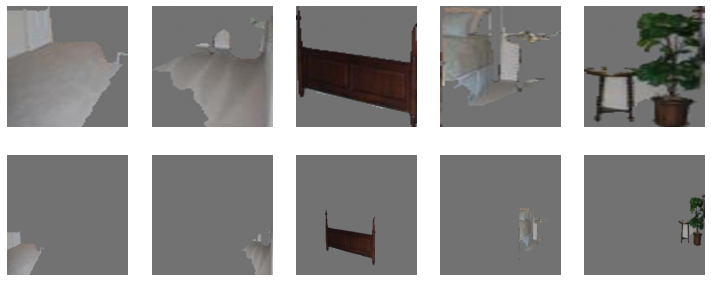

(<Figure size 900x360 with 10 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

In [41]:
n_show = 5
start = 98

superpixels = cd.dataset
print(cd.image_numbers[start:start+n_show])
show_image_rows(
    images=[cd.dataset[start:start+n_show], cd.patches[start:start+n_show]])

## Load model, pass the superpixel patches through and save feature activations

Loaded model


In [ ]:
print(model.named_modules())
print(model)


In [61]:
cd.get_features(
    features_model=features_model,
    device=device,
    batch_size=batch_size)

cd.print_shapes()
cd.save()

100%|███████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Dataset (superpixel) shape: (1109, 224, 224, 3)
Image numbers shape: (1109,)
Patches shape: (1109, 224, 224, 3)
Features shape: (1109, 512)
Saved dataset, image numbers, and patches to temp_save/cd_data.pth


In [7]:
restore_path = 'temp_save/cd_data.pth'

cd = ConceptDiscovery(
    average_image_value=average_pixel_value,
    image_shape=image_shape,
    num_workers=num_workers)

cd.restore(restore_path)
cd.print_shapes()



Dataset (superpixel) shape: (1109, 224, 224, 3)
Image numbers shape: (1109,)
Patches shape: (1109, 224, 224, 3)
Features shape: (1109, 512)


In [8]:
cluster_method = 'KM'
KM_params = {
    'n_clusters': 25
}
concept_centers, concept_image_data = cd.discover_concepts(
    cluster_params=KM_params,
    cluster_method=cluster_method,
    save=True)
# assignments, costs, centers = cd._cluster_patches(
#     cluster_params=KM_params,
#     cluster_method=cluster_method)

/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
Saved concept image data to temp_save/concept_images.pth


In [9]:
print(type(concept_image_data[0]['images']))
print(concept_image_data[0]['images'].shape)
concept_save_dir = 'temp_save'
concepts = cd.get_features_for_concepts(
     model=features_model,
     device=device,
     concepts=concept_image_data,
     batch_size=batch_size,
     save_dir=concept_save_dir,
     channel_mean=True)


<class 'numpy.ndarray'>
(40, 224, 224, 3)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.94it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.09it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.41it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 21.66it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.99it/s]


(29, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.46it/s]


(30, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.87it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.73it/s]


(23, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.97it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.53it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.22it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.41it/s]


(35, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.88it/s]


(26, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.34it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.67it/s]


(38, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.45it/s]


(19, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.42it/s]


(24, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


(38, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.21it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.27it/s]


(40, 512)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.32it/s]


(40, 512)
Saved concept features to temp_save/concept_activations.pth


dict_keys(['images', 'patches', 'image_numbers', 'features'])
(18, 512)
(18, 224, 224, 3)


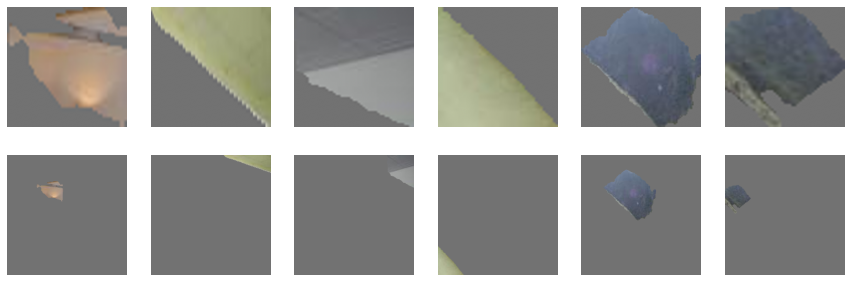

(<Figure size 1080x360 with 12 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
       dtype=object))

In [28]:
print(concepts[0].keys())
print(concepts[0]['features'].shape)
print(concepts[0]['images'].shape)
